In [1]:
# Classifying names with a character level Recurrent  Neural Network

import pandas as pd
import glob
import string
import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt
from pandas_ml import ConfusionMatrix
import numpy as np

In [2]:
file_path = 'datasets/name_by_language/names' # declare file dir on OS
allFiles = glob.glob(file_path + "/*.txt") # save to allFiles var in list

In [3]:
names_data = pd.DataFrame() # create empty dataframe
list_ = [] # create empty list

In [4]:
for file_ in allFiles: # read files from csv
    df = pd.read_csv(
        file_, sep='/n',
        names=['Name'],
        engine="python",
        error_bad_lines=False)
    df['Language'] = str(file_.split('/names\\')[-1].split('.')[0])
    
    list_.append(df)
    names_data = pd.concat(list_)

In [5]:
names_data.sample(10) # smple 10 names/languages

,Name,Language
316,Peisar,Czech
601,Obinata,Japanese
243,Ishihara,Japanese
260,Torres,Spanish
207,Roijackers,Dutch
16,Che,Chinese
438,Suchanka,Czech
199,Rian,Irish
147,O'Brian,Irish
103,Koning,Dutch


In [6]:
languages = names_data['Language'].unique() # create languages var which holds each unique language as array

In [7]:
languages

array(['Arabic', 'Chinese', 'Czech', 'Dutch', 'French', 'German', 'Greek',
       'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Scottish',
       'Spanish', 'Vietnamese'], dtype=object)

In [8]:
len(languages) # 15 uniques languages

15

In [9]:
len(names_data) # 4994 names

4994

In [10]:
names_data = names_data.drop_duplicates() # drop duplicate names
len(names_data) # 4931 unique names

4931

In [11]:
all_letters = string.ascii_letters + " .,;'" # set up characters needed for one-hot encoding vector
n_letters = len(all_letters)
all_letters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'"

In [12]:
def name_to_tensor(name): # helper function to one-hot encode the charactes in the nanmes
    name_in_tensor = torch.zeros(len(name), 1, n_letters) # init a tensor with all zeros 
    for i, letter in enumerate(name): # one-hot encoding
        name_in_tensor[i][0][all_letters.find(letter)] = 1 
    
    return name_in_tensor

In [13]:
name_to_tensor('a') # test one-hot encoding helper function

tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]]])

In [14]:
name_to_tensor('a A') # test again

tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]]])

In [15]:
class RNN(nn.Module):    
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self): # used to init hidden state
        return torch.zeros(1, self.hidden_size)

In [16]:
n_hidden = 128
n_languages = len(languages)

In [17]:
rnn = RNN(n_letters, n_hidden, output_size = n_languages) # set up RNN

In [18]:
iterations = 100000
criterion = nn.NLLLoss()
learning_rate = 0.005

In [19]:
def output_to_language(output): # helper function to predict language
    top_n, top_index = output.topk(1)
    pred_i = top_index[0].item()
    pred = languages[pred_i]
    
    return pred

In [20]:
current_loss = 0
all_losses = []

In [21]:
for iteration in range(1, iterations + 1):
    i = random.randint(0, len(names_data) - 1) # pick at random from the data-set
    
    name = names_data.iloc[i][0] # pick the name at the randomly generated index
    name_in_tensor = name_to_tensor(name) # encode name in one-hot form
    
    language = names_data.iloc[i][1] # access the language associated with the name in (i) row and index [1]
    language_in_tensor = torch.tensor([list(languages).index(language)], dtype=torch.long) # set it up as tensor
    
    hidden = rnn.initHidden()
    rnn.zero_grad()
    
    for i in range(name_in_tensor.size()[0]): # iterate through every character in the name tensor
        output, hidden = rnn(name_in_tensor[i], hidden) # At each time instance pass in the current character and the previous hidden output to the RNN
        
    loss = criterion(output, language_in_tensor)
    loss.backward()
    
    current_loss += loss.item()
    
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)
        
    if iteration % 5000 == 0:
        pred = output_to_language(output)
        
        correct = '✔' if pred == language else '✗ (%s)' % language
        
        print('iters- %d %d%% (%s) Name- %s Language- %s %s' %(
            iteration,
            iteration/iterations*100,
            loss.item(),
            name, pred, correct))
    
    if iteration % 1000 == 0:
        all_losses.append(current_loss / 1000)
        current_loss = 0

iters- 5000 5% (1.7204009294509888) Name- Stark Language- Japanese ✗ (German)
iters- 10000 10% (0.036963462829589844) Name- Kawagishi Language- Japanese ✔
iters- 15000 15% (2.841240406036377) Name- Thao Language- Chinese ✗ (Vietnamese)
iters- 20000 20% (0.2618284225463867) Name- WÃ¤gner Language- German ✔
iters- 25000 25% (1.217604398727417) Name- Koch Language- Czech ✗ (German)
iters- 30000 30% (2.7171988487243652) Name- Smits Language- German ✗ (Dutch)
iters- 35000 35% (0.0004425048828125) Name- Kunikida Language- Japanese ✔
iters- 40000 40% (0.1998734474182129) Name- Acciaio Language- Italian ✔
iters- 45000 45% (0.9182744026184082) Name- Roijakker Language- Dutch ✔
iters- 50000 50% (0.02096271514892578) Name- Ohmiya Language- Japanese ✔
iters- 55000 55% (2.849431037902832) Name- Duncan Language- Irish ✗ (Scottish)
iters- 60000 60% (0.16409540176391602) Name- Kringos Language- Greek ✔
iters- 65000 65% (0.16548871994018555) Name- Corti Language- Italian ✔
iters- 70000 70% (1.609628200

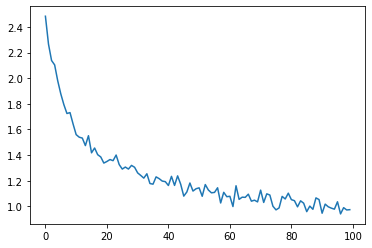

In [22]:
plt.figure()
plt.plot(all_losses)

In [23]:
# confusion matrix for defining model accuracy
n_confusion = 10000

prediction = []
actual = []

for _ in range(n_confusion):
    
    i = random.randint(0, len(names_data) - 1) # pick at random from the data-set
    
    name = names_data.iloc[i][0] # pick the name at the randomly generated index
    name_in_tensor = name_to_tensor(name) # encode name in one-hot form
    
    language = names_data.iloc[i][1] # access the language associated with the name in (i) row and index [1]
    language_in_tensor = torch.tensor([list(languages).index(language)], dtype=torch.long) # set it up as tensor
    
    hidden = rnn.initHidden()
    
    for i in range(name_in_tensor.size()[0]): # iterate through every character in the name tensor
        output, hidden = rnn(name_in_tensor[i], hidden) # At each time instance pass in the current character and the previous hidden output to the RNN
        
    pred = output_to_language(output)
    
    prediction.append(pred)
    actual.append(language)

In [24]:
confusion_matrix = ConfusionMatrix(actual, prediction) # confusion matrix from pandas ml library

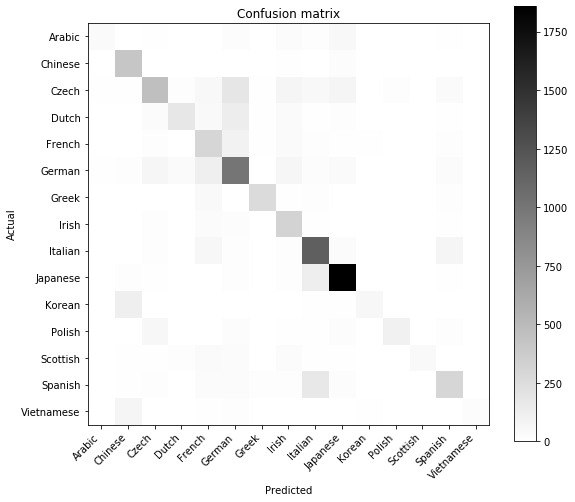

In [25]:
confusion_matrix.plot()